In [167]:
#%pwd
#%pip list

In [1]:
import time
import dash
from dash import dcc, html
from dash.dependencies import Output, Input
import plotly.graph_objs as go
import numpy as np
from qick import *
from qick.asm_v2 import AveragerProgramV2
from qick.asm_v2 import QickSweep1D
from qick.asm_v2 import AsmV2
import matplotlib.pyplot as plt
from qick import QickProgram, AcquireProgram, QickRegister, AcquireMixin
import Pyro4

class TofProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['readout_length'])
        self.add_readoutconfig(ch=ro_ch, name="ro", freq=cfg['freq'], gen_ch=gen_ch, phase=0, outsel='product')        
        self.add_pulse(ch=gen_ch, name="tofpulse", ro_ch=ro_ch, style=cfg['pulse_style'], freq=cfg['freq'], length=cfg['pulse_length'], phase=0, gain=cfg['pulse_gain'])
        self.send_readoutconfig(ch=ro_ch, name="ro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="tofpulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['adc_trig_offset'])

class QickInstrument():
    def __init__(self, ip_addr = "192.168.2.99"):
        Pyro4.config.SERIALIZER = "pickle"
        Pyro4.config.PICKLE_PROTOCOL_VERSION=4
        ns_host = ip_addr# change according to setings..
        ns_port = 8888
        proxy_name = "myqick"
        ns = Pyro4.locateNS(host=ns_host, port=ns_port)
        for k,v in ns.list().items():
            print(k,v)
        self.soc = Pyro4.Proxy(ns.lookup(proxy_name))
        self.soccfg = QickConfig(self.soc.get_cfg())
        print(self.soccfg)
        self.trig_off = 0
        self.ro_pulse_counter = 0
        self.drive_pulse_counter = 0
        self.drive_DC_pulse_counter = 0
        self.long_ro_pulse_counter = 0
        self.nb_readout = []
        self.COUNTER_ADDR = 1

    def _raz(self):
        self.ro_pulse_counter = 0
        self.drive_pulse_counter = 0
        self.drive_DC_pulse_counter = 0
        self.long_ro_pulse_counter = 0
        self.nb_readout = []
        self.COUNTER_ADDR = 1

    def tof_measure(self, gen_port, ro_port, freq, amplitude, ro_duration, ro_pulse_duration):
        if ro_pulse_duration > self.soccfg['gens'][0]['maxlen']/(self.soccfg['gens'][0]['samps_per_clk']*self.soccfg['gens'][0]['f_fabric']):
            print("Pulse longer than: ", self.soccfg['gens'][0]['maxlen']/(self.soccfg['gens'][0]['samps_per_clk']*self.soccfg['gens'][0]['f_fabric']), " us")
            return(1)
        config_tof = {"gen_ch":gen_port, # --Fixed
                   "ro_ch":ro_port, # --Fixed
                   "pulse_style": "const", # --Fixed
                   "pulse_length":ro_pulse_duration, # [us]
                   "readout_length":ro_duration, # [us]
                   "pulse_gain":amplitude, # [V]
                   "freq":freq, # [MHz]
                   "adc_trig_offset": 0, # [us]
                   "nqz": 1,
                   }
        prog = TofProgram(self.soccfg, reps=1, final_delay=0, cfg=config_tof)
        iq_list = prog.acquire_decimated(self.soc, soft_avgs=10, progress=False)
        magnitude = np.abs(iq_list[0][:,0] + 1j*iq_list[0][:,1])
        t = prog.get_time_axis(ro_index=0)
        trig1 = 150
        trig2 = 0
        try:
            trig1 = np.where(magnitude > 25)[0][0]-50
            config_tof["adc_trig_offset"] = t[trig1]
            config_tof["readout_length"] = 1
            config_tof["pulse_length"] = 0.5
        except:
            print("No connection between emitter and receiver")
        prog = TofProgram(self.soccfg, reps=1, final_delay=0, cfg=config_tof)
        iq_list = prog.acquire_decimated(self.soc, soft_avgs=10, progress=False)
        magnitude = np.abs(iq_list[0][:,0] + 1j*iq_list[0][:,1])
        try:
            trig2 = np.where(magnitude > 25)[0][0]
        except:
            print("No connection between emitter and receiver")
        self.trig_off = t[trig1+trig2]
        print("trigger offset: ", self.trig_off, " us", self.soccfg.us2cycles(self.trig_off), "tproc cycles")
        return(self.trig_off)

    def config_channels(self, drive_gen_port, drive_nqz, ro_gen_port, ro_port, ro_freq, ro_duration, style = "const", reps=1, rep_wait=1.0, init_wait=10.0):
        self._raz()
        self.qick_program = AcquireProgramV2(self.soccfg) # in asm_v2.py
        self.ro_duration = ro_duration
        self.reps = reps
        self.rep_wait = rep_wait
        self.init_wait = init_wait
        self.ro_freq = ro_freq
        for i in range(0, len(drive_gen_port)):
            self.qick_program.declare_gen(ch=drive_gen_port[i], nqz=drive_nqz[i])
        if ro_freq > self.soccfg['gens'][ro_gen_port]['fs']/2:
            ro_nqz = 2
        else:
            ro_nqz = 1
        self.qick_program.declare_gen(ch=ro_gen_port, nqz=ro_nqz)
        self.qick_program.declare_readout(ch=ro_port, length=self.ro_duration)
        self.qick_program.add_readoutconfig(ch=ro_port, name="ro", freq=ro_freq, gen_ch=ro_gen_port, outsel='product')
        self.qick_program.send_readoutconfig(ch=ro_port, name="ro", t=0)
        if self.init_wait != 0:     # voir asm_v2.py class AveragerProgramV2 methode make_program
            self.qick_program.delay_auto(self.init_wait)
        self.qick_program.open_loop(reps, name="main_loop")

    def add_readout_pulse(self, ro_gen_port, ro_port, amplitude, duration, phase, abs_time, style="const"):
        pulse_name = "ro_pulse_" + str(self.ro_pulse_counter)
        max_pulse_duration = self.soccfg.cycles2us(gen_ch=ro_gen_port, cycles=2**16)
        if duration <= max_pulse_duration:
            self.qick_program.add_pulse(ch=ro_gen_port, name=pulse_name, ro_ch=ro_port, style=style, freq=self.ro_freq, length=duration, phase=phase, gain=amplitude)
            self.qick_program.pulse(ch=ro_gen_port, name=pulse_name, t=abs_time)
            self.qick_program.trigger(ros=[ro_port], pins=[0], t=self.trig_off+abs_time+(duration-self.ro_duration)/2)
            self.ro_pulse_counter += 1
        else:
            print("Pulse readout trop longue, utiliser add_long_readout")
            
    def add_long_readout(self, ro_gen_port, ro_port, amplitude, duration, phase, abs_time, style="const"):
        pulse_name = "long_ro_pulse_" + str(self.long_ro_pulse_counter)
        self.nb_readout.append(int(duration/(1.02*self.ro_duration)))  
        pulse_duration = 1.02*self.ro_duration   # pulse duration 2 percent longer than readout duration due to readout issue when pulse duration = readout duration
        duration = self.nb_readout[-1]*pulse_duration
        print("number of readouts: ", self.nb_readout, "actual pulse duration: ", duration, " us")
        self.qick_program.add_pulse(ch=ro_gen_port, name=pulse_name, style=style, freq=self.ro_freq, length=pulse_duration, phase=phase, gain=amplitude, phrst=0)
        print(self.soccfg.us2cycles(self.trig_off+abs_time+0.01*pulse_duration))
        steps = QickSweep1D(pulse_name+"_loop", 0, duration)
        self.qick_program.open_loopV2(self.nb_readout[-1], name=pulse_name+"_loop")
        self.qick_program.pulse(ch=ro_gen_port, name=pulse_name, t=steps+abs_time)
        self.qick_program.trigger(ros=[ro_port], pins=[0], t=self.trig_off+steps+abs_time+0.01*pulse_duration) # center trigger at middle of pulse duration
        self.qick_program.close_loopV2()
        self.long_ro_pulse_counter += 1
        
    def add_drive_pulse(self, drive_gen_port, amplitude, duration, phase, freq, abs_time, style="const"):
        pulse_name = "drive_pulse_" + str(self.drive_pulse_counter)
        max_pulse_duration = self.soccfg.cycles2us(gen_ch=drive_gen_port, cycles=2**16)
        if duration >= max_pulse_duration:
            nb_pulses = int(duration/max_pulse_duration)+1
            pulse_duration = duration/nb_pulses
            self.qick_program.add_pulse(ch=drive_gen_port, name=pulse_name, style=style, freq=freq, length=pulse_duration, phase=phase, gain=amplitude, phrst=0)
            steps = QickSweep1D(pulse_name+"_loop", pulse_duration, duration)
            self.qick_program.open_loop(nb_pulses, name=pulse_name+"_loop")
            self.qick_program.pulse(ch=drive_gen_port, name=pulse_name, t=abs_time+steps-pulse_duration)  # il n'y a pas besoin d'incrémenter le temps.. ??? jusqu'à un nb de loop de 10...
            self.qick_program.close_loop()
        else:
            self.qick_program.add_pulse(ch=drive_gen_port, name=pulse_name, style=style, freq=freq, length=duration, phase=phase, gain=amplitude, phrst=0)
            self.qick_program.pulse(ch=drive_gen_port, name=pulse_name, t=abs_time)
        self.drive_pulse_counter += 1

    def add_DC_pulse(self, drive_gen_port, amplitude, duration, abs_time):
        pulse_name = "drive_DC_pulse_" + str(self.drive_DC_pulse_counter)
        max_pulse_duration = self.soccfg.cycles2us(gen_ch=drive_gen_port, cycles=2**16)
        if duration >= max_pulse_duration:
            nb_pulses = int(duration/max_pulse_duration)+1
            pulse_duration = duration/nb_pulses
            self.qick_program.add_pulse(ch=drive_gen_port, name=pulse_name, style="const", freq=0, length=duration/nb_pulses, phase=0, gain=amplitude, phrst=1)
            steps = QickSweep1D(pulse_name+"_loop", pulse_duration, duration)
            self.qick_program.open_loop(nb_pulses, name=pulse_name)
            self.qick_program.pulse(ch=drive_gen_port, name=pulse_name, t=abs_time+steps-pulse_duration)
            self.qick_program.close_loop()
        else:
            self.qick_program.add_pulse(ch=drive_gen_port, name=pulse_name, style="const", freq=0, length=duration, phase=0, gain=amplitude, phrst=1)
            self.qick_program.pulse(ch=drive_gen_port, name=pulse_name, t=abs_time)
        self.drive_DC_pulse_counter += 1
    
    def show_sequence(self):
        pass
    def setup(self):
        loop_dims = [self.reps]
        self.qick_program.setup_acquire(counter_addr=1, loop_dims=loop_dims, avg_level=0)
        if self.long_ro_pulse_counter != 0:
            self.qick_program.set_reads_per_shot(np.sum(self.nb_readout))
        #print(self.qick_program)
        
    def make_program(self):
        self.qick_program.wait_auto(0, no_warn=True)   # voir asm_v2.py class AveragerProgramV2 methode make_program
        self.qick_program.delay_auto(self.rep_wait)
        self.qick_program.inc_ext_counter(addr=self.COUNTER_ADDR)
        self.qick_program.close_loop()
        self.qick_program.end()
        self.qick_program.config_all(self.soc)
        loop_dims = [self.reps]
        self.qick_program.setup_acquire(counter_addr=1, loop_dims=loop_dims, avg_level=0)
        if self.long_ro_pulse_counter != 0:
            print(np.sum(self.nb_readout))
            self.qick_program.set_reads_per_shot(np.sum(self.nb_readout))
        print(self.qick_program)
        
    def run_sequence(self):
        ret = self.qick_program.acquire(self.soc, threshold=None, angle=None, load_pulses=True, progress=False, remove_offset=False)[0]
        return(ret)
        

        

In [2]:
program = QickInstrument("192.168.2.99")

QICK library version mismatch: 0.2.291 remote (the board), 0.2.295 local (the PC)
                        This may cause errors, usually KeyError in QickConfig initialization.
                        If this happens, you must bring your versions in sync.


Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_7f2cc45986864c9f9f69f130db539832@192.168.2.99:37641
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Fri Nov 29 08:55:09 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 i

In [ ]:
a = program.tof_measure(14, 0, 150, 1, 2, 1) # gen_port, ro_port, freq, amplitude, ro_duration, ro_pulse_duration
program.config_channels([12, 15], [1, 1], 14, 0, 100, 1, reps=1, rep_wait=1) # drive_gen_port, drive_nqz, ro_gen_port, ro_port, ro_freq, ro_duration, style = "const", reps=1, rep_wait=1)
#program.add_drive_pulse(15, 1, 2, 0, 50, 0) # drive_gen_port, amplitude, duration, phase, freq, abs_time, style="const"
#program.add_readout_pulse(14, 0, 1, 1, 0, 0)  # ro_gen_port, ro_port, amplitude, duration, phase, abs_time, style="const"
program.add_long_readout(14, 0, 0.3, 8455, 0, 0)
#program.loop(5)
program.make_program()
a = program.run_sequence()
print(a)

assigned addresses:  set()
reg full addr r0
time register:  860
assembler, labels:  {'s15': 's15', 'reps': '&6'}
assigned addresses:  set()
reg full addr r0
time register:  532
assembler, labels:  {'s15': 's15', 'reps': '&6'}
trigger offset:  0.400390625  us 172 tproc cycles
number of readouts:  [8289] actual pulse duration:  8454.78  us
177
assigned addresses:  set()
reg full addr r0
assigned addresses:  {0}
reg full addr sweep r13 name:  r13
assigned addresses:  {0, 13}
reg full addr sweep r14 name:  r14
assigned addresses:  {0, 13, 14}
reg full addr sweep r15 name:  r15
time register:  3636838
assembler, labels:  {'s15': 's15', 'main_loop': '&5', 'long_ro_pulse_0_loop': '&9'}
8289
macros:
	ConfigReadout(ch=0, name='ro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x00000199A8C81130>}, t_regs={'t': 0})
	Delay(t=10.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x00000199982AD9A0>}, t_regs={'t': 4301})
	OpenLoop(n=1, nam

In [25]:
a = program.tof_measure(14, 0, 150, 1, 2, 1) # gen_port, ro_port, freq, amplitude, ro_duration, ro_pulse_duration

assigned addresses:  set()
reg full addr r0
time register:  860
assembler, labels:  {'s15': 's15', 'reps': '&6'}
assigned addresses:  set()
reg full addr r0
time register:  532
assembler, labels:  {'s15': 's15', 'reps': '&6'}
trigger offset:  0.400390625  us 172 tproc cycles


number of readouts:  [39] actual pulse duration:  198.89999999999998  us
21698
number of readouts:  [39, 41] actual pulse duration:  209.1  us
129218
number of readouts:  [39, 41, 43] actual pulse duration:  219.29999999999998  us
241039
number of readouts:  [39, 41, 43, 45] actual pulse duration:  229.49999999999997  us
357161
number of readouts:  [39, 41, 43, 45, 47] actual pulse duration:  239.7  us
477583
number of readouts:  [39, 41, 43, 45, 47, 49] actual pulse duration:  249.89999999999998  us
602306
number of readouts:  [39, 41, 43, 45, 47, 49, 50] actual pulse duration:  254.99999999999997  us
731330
number of readouts:  [39, 41, 43, 45, 47, 49, 50, 52] actual pulse duration:  265.2  us
864655
number of readouts:  [39, 41, 43, 45, 47, 49, 50, 52, 54] actual pulse duration:  275.4  us
1002281
number of readouts:  [39, 41, 43, 45, 47, 49, 50, 52, 54, 56] actual pulse duration:  285.59999999999997  us
1144207
number of readouts:  [39, 41, 43, 45, 47, 49, 50, 52, 54, 56, 58] actua

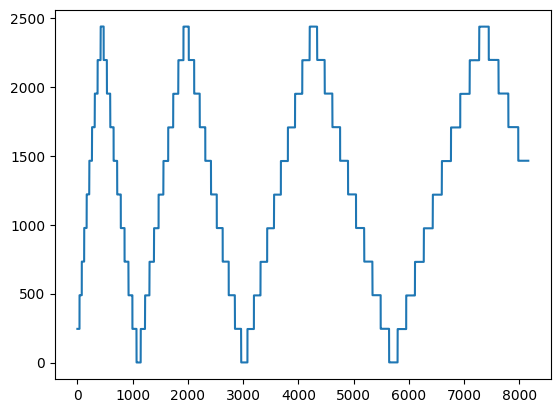

In [26]:
program.config_channels([12, 15], [1, 1], 14, 0, 100, 5, reps=10, rep_wait=10000) # drive_gen_port, drive_nqz, ro_gen_port, ro_port, ro_freq, ro_duration, style = "const", reps=1, rep_wait=1)
for i in range(0,74):
    j = i
    program.add_DC_pulse(12, 1, 25, 0+j*(50+200+10*(j-1)/2)) # drive_gen_port, amplitude, duration, abs_time)
    program.add_DC_pulse(12, -1, 25, 25+j*(50+200+10*(j-1)/2)) # drive_gen_port, amplitude, duration, abs_time)
    program.add_drive_pulse(15, 1, 2, 0, 50, 48+j*(50+200+10*(j-1)/2)) # drive_gen_port, amplitude, duration, phase, freq, abs_time, style="const"
    program.add_long_readout(14, 0, 0.1*(j+1), 200 + 10*j, 0, 50+i*(50+200+10*(j-1)/2)) # ro_gen_port, ro_port, amplitude, duration, phase, abs_time, style="const"
    #program.make_progv2()
program.make_program()
    #program.setup()
a = program.run_sequence()
plt.figure()
plt.plot(np.abs(a[:,0]+1j*a[:,1]))
plt.show()

In [66]:
#%timeit program.run_sequence()